In [2]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Load 9x9 images taken from 2187x2187 images
layers = "../supervised_convnet/t_2.269/layer_by_layer/"
fine = "../supervised_convnet/t_2.269/x3x3/ising_temp2.269_correlated9x9from2187x2187.npy"
fine = np.load(fine)

In [3]:
torch.__file__

'/Users/alng/opt/anaconda3/envs/rtsynth/lib/python3.8/site-packages/torch/__init__.py'

In [4]:
fine.shape

(10000, 9, 9)

In [3]:
import numpy as np
v = np.random.randn((2187))

In [21]:
i = np.random.randint(2187)
print(i)

2078


In [22]:
c = np.concatenate([v[:i], v[(i + 1):]])

In [23]:
c.shape

(2186,)

In [27]:
c[2075:2085]

array([-1.8358306 , -0.54896313,  1.56556533, -0.09338653, -1.13503142,
       -0.40241476,  0.06771404,  1.01817865, -0.52089454, -0.89903694])

In [26]:
v[2075:2085]

array([-1.8358306 , -0.54896313,  1.56556533, -0.12470246, -0.09338653,
       -1.13503142, -0.40241476,  0.06771404,  1.01817865, -0.52089454])

# Compute Fine-grained MI 

In [3]:
def sample_xy(data = fine, batch_size = 128):
    """
    Sample 3x6 rectangles from the fine grained data
    """
    num_samples, xdim, ydim = data.shape
    indices = np.random.randint(len(data), size = batch_size)
    arr = []
    for ind in indices:
        x, y = np.random.randint(xdim, size = 2)
        tmp = np.pad(data[ind], 6, mode = "wrap")[x:(x+3), y:(y+6)]
        arr.append(tmp)
    return np.stack(arr)
        
def get_xy():
    """
    Get 3x3 squares from 3x6 rectangles
    """
    data = sample_xy()
    x = data[:, :3, :3].reshape(-1, 9)
    y = data[:, :3, 3:].reshape(-1, 9)
    return x, y


In [4]:
x, y = get_xy()
x[:10], y[:10]

(array([[0, 1, 1, 1, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]), array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [8]:
S=9
H=150
n_epoch = 2000
data_size = 20000

class Net(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self):
        super(Net, self).__init__()
        self.x_fc1 = nn.Linear(S, S)
        self.x_fc2 = nn.Linear(S, S)
        self.x_fc3 = nn.Linear(S, H)
        
        self.y_fc1 = nn.Linear(S, S)
        self.y_fc2 = nn.Linear(S, S)
        self.y_fc3 = nn.Linear(S, H)
        
        self.fc3 = nn.Linear(H, 1)
        
        
    def forward(self, x, y):
        inter_x = x + F.relu(self.x_fc1(x))
        # inter_x = inter_x + F.relu(self.x_fc2(inter_x))
        inter_x = self.x_fc3(inter_x)
        
        inter_y = y + F.relu(self.y_fc1(y))
        # inter_y = inter_y + F.relu(self.y_fc2(inter_y))
        inter_y = self.y_fc3(inter_y)
        
        
        h1 = F.relu(inter_x + inter_y)
        h2 = self.fc3(h1)
        return h2    

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    # Get samples from the joint distribution
    x_sample, y_sample=get_xy()
    
    # Get samples from the marginal distribution
    # by shuffling the joint samples
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor), requires_grad = True)    
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    # MINE estimator
    ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = - ret  # maximize MI
    plot_loss.append(loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 2000/2000 [01:54<00:00, 17.48it/s]


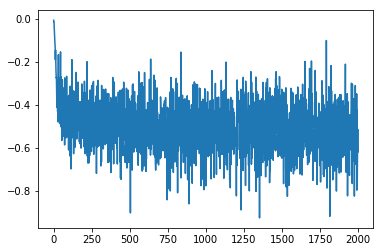

In [9]:
import matplotlib.pyplot as plt
plt.plot(plot_loss)
plt.show()

In [22]:
print(model.parameters)

for p in model.parameters():
    print(p)

<bound method Module.parameters of Net(
  (x_fc1): Linear(in_features=9, out_features=9, bias=True)
  (x_fc2): Linear(in_features=9, out_features=9, bias=True)
  (x_fc3): Linear(in_features=9, out_features=15, bias=True)
  (y_fc1): Linear(in_features=9, out_features=9, bias=True)
  (y_fc2): Linear(in_features=9, out_features=9, bias=True)
  (y_fc3): Linear(in_features=9, out_features=15, bias=True)
  (fc3): Linear(in_features=15, out_features=1, bias=True)
)>
Parameter containing:
tensor([[-0.2024,  0.3144, -0.1407, -0.0241, -0.2911,  0.2497, -0.2274, -0.0521,
          0.0135],
        [ 0.3172,  0.1078,  0.4976, -0.0796,  0.2526,  0.1883,  0.1112, -0.2759,
          0.1730],
        [-0.0341,  0.2580,  0.2995,  0.1361, -0.0381,  0.2025,  0.0446,  0.3215,
          0.0659],
        [ 0.0224, -0.1906,  0.4629,  0.1273,  0.2260,  0.4661, -0.1531,  0.0786,
          0.4210],
        [-0.0189,  0.1458, -0.0267,  0.3596, -0.2041, -0.2131,  0.3172,  0.0826,
          0.0392],
        [-0.16

# Optimize Coarse-graining to maximize MINE

In [1]:
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
arrs = []
# for arr in tqdm(glob("../data_2187_1571810501/*")[2500:5000]):
#     z = np.load(arr)['arr_0']
#     x, y = np.random.randint(2187, size=2)
#     z = np.pad(z, pad_width=27, mode='wrap')[x:(x+27), y:(y+27)]
#     arrs.append(z)
# arrs = np.stack(arrs)

arrs = np.load("./ising27x27from2187x2187.npy")[:, None, :, :]
arrs.shape

(10001, 1, 27, 27)

## Took 9x9 image from 2187x2187 equilibrium Ising
Get 3x6 rectangles

Use MINE to compute the MI of fine-grained model

In [1]:
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
arrs = []
 
# Load 27x27 images
arrs = np.load("./ising27x27from2187x2187.npy")[:, None, :, :]
arrs.shape

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
S=9
H=150
n_epoch = 100
data_size = 20000
def pad_circular(x, pad):
    """
    function inspired by https://github.com/pytorch/pytorch/issues/3858
    Pad a tensor with periodic boundary conditions
    Used to get subsets of an image
    :param x: shape [H, W]
    :param pad: int >= 0
    :return:
    """
    x = torch.cat([x, x[0:pad]], dim=0)
    x = torch.cat([x, x[:, 0:pad]], dim=1)
    x = torch.cat([x[-2 * pad:-pad], x], dim=0)
    x = torch.cat([x[:, -2 * pad:-pad], x], dim=1)

    return x

class Net(nn.Module):
    def __init__(self, out_channels = 1, filter_size = 3):
        super(Net, self).__init__()
        
        self.x_fc1 = nn.Linear(S, S)
        self.x_fc2 = nn.Linear(S, S)
        self.x_fc3 = nn.Linear(S, H)
        
        self.y_fc1 = nn.Linear(S, S)
        self.y_fc2 = nn.Linear(S, S)
        self.y_fc3 = nn.Linear(S, H)
        
        self.fc3 = nn.Linear(H, 1)
        
        self.conv1 = nn.Conv2d(1, out_channels, filter_size, padding=0, stride = filter_size)
        
        
    def MI_net(self, x, y):
        inter_x = x + F.relu(self.x_fc1(x))
        inter_x = inter_x + F.relu(self.x_fc2(inter_x))
        inter_x = self.x_fc3(inter_x)
        
        inter_y = y + F.relu(self.y_fc1(y))
        inter_y = inter_y + F.relu(self.y_fc2(inter_y))
        inter_y = self.y_fc3(inter_y)
        
        
        h1 = F.relu(inter_x + inter_y)
        h2 = self.fc3(h1)
        return h2  
    
    def forward(self, x):
        # coarse grain 27x27 model to get 9x9 model
        x = (self.conv1(x))
        
        rectangle = []
        # get a random 3x6 rectangle
        for data in x:
            i, j = np.random.randint(x.size()[2], size = 2) 
            rectangle.append( pad_circular(data[0], 6)[i:(i+3), j:(j+6)])
            

        rectangle = torch.stack(rectangle)
        # separate rectangle into 2 patches of shape 3x3 
        patch1 = rectangle[:, :3, :3].reshape(-1, 9)
        patch2 = rectangle[:, :3, 3:].reshape(-1, 9)
        patch2_shuffled = patch2[torch.randperm(patch2.shape[0])]
        
        # compute MI
        pred_xy = self.MI_net(patch1, patch2)
        pred_x_y = self.MI_net(patch1, patch2_shuffled)
        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        return -ret
        
class IsingDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, arrs):
        'Initialization'
        self.arrs = torch.Tensor(arrs)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.arrs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.arrs[index] 
    
# Generators
# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
training_set = IsingDataset(arrs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    for batch_id, x in enumerate(training_generator):
        loss = model(x)
        plot_loss.append(loss.data.numpy())
        model.zero_grad()
        loss.backward()
        optimizer.step()

        
        
        

100%|██████████| 100/100 [03:51<00:00,  2.31s/it]


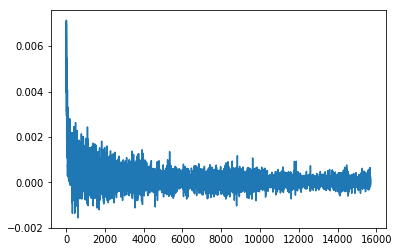

In [15]:
plt.plot(plot_loss)

## Took 9x9 image from 2187x2187 equilibrium Ising with a 3x3 filter to Coarse-grain to 3x3

Get 1x2 rectangles

Use MINE to compute the MI of fine-grained model


In [3]:
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
arrs = []
# for arr in tqdm(glob("../data_2187_1571810501/*")[2500:5000]):
#     z = np.load(arr)['arr_0']
#     x, y = np.random.randint(2187, size=2)
#     z = np.pad(z, pad_width=27, mode='wrap')[x:(x+27), y:(y+27)]
#     arrs.append(z)
# arrs = np.stack(arrs)

arrs = np.load("./ising27x27from2187x2187.npy")[:, None, :, :]
arrs = np.pad(arrs, [(0, 0), (0, 0), (9, 9), (9, 9)], mode='wrap') 

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
S=9
H=15
n_epoch = 100
data_size = 20000
def pad_circular(x, pad):
    """
    function inspired by https://github.com/pytorch/pytorch/issues/3858
    :param x: shape [H, W]
    :param pad: int >= 0
    :return:
    """
    x = torch.cat([x, x[0:pad]], dim=0)
    x = torch.cat([x, x[:, 0:pad]], dim=1)
    x = torch.cat([x[-2 * pad:-pad], x], dim=0)
    x = torch.cat([x[:, -2 * pad:-pad], x], dim=1)

    return x

class Net(nn.Module):
    def __init__(self, out_channels = 1, filter_size = 3):
        super(Net, self).__init__()
        
        self.x_fc1 = nn.Linear(1, S)
        self.x_fc2 = nn.Linear(S, S)
        self.x_fc3 = nn.Linear(S, H)
        
        self.y_fc1 = nn.Linear(1, S)
        self.y_fc2 = nn.Linear(S, S)
        self.y_fc3 = nn.Linear(S, H)
        
        self.fc3 = nn.Linear(H, 1)
        
        self.conv1 = nn.Conv2d(1, out_channels, filter_size, padding=0, stride = filter_size)
        
        
    def MI_net(self, x, y):
        inter_x = F.relu(self.x_fc1(x))
        inter_x = inter_x + F.relu(self.x_fc2(inter_x))
        inter_x = self.x_fc3(inter_x)
        
        inter_y = F.relu(self.y_fc1(y))
        inter_y = inter_y + F.relu(self.y_fc2(inter_y))
        inter_y = self.y_fc3(inter_y)
        
        
        h1 = F.relu(inter_x + inter_y)
        h2 = self.fc3(h1)
        return h2  
    
    def forward(self, x):
        # get 9x9 model from 27x27 data: random crop
        i, j = np.random.randint(9, size = 2) 
        x = x[:, :, i:(i+9),j:(j+9)]
        
        # coarse grain 9x9 model to get 3x3 model
        x = (self.conv1(x))
        
        
        rectangle = []
        # get a random 1x2 rectangle
        for data in x:
            i, j = np.random.randint(3, size = 2) 
            rectangle.append( pad_circular(data[0], 2)[i, j:(j+2)])
            

        rectangle = torch.stack(rectangle)
        # separate rectangle into 2 patches of shape 3x3 
        patch1 = rectangle[:, 0].reshape(-1, 1)
        patch2 = rectangle[:, 1].reshape(-1, 1)
        patch2_shuffled = patch2[torch.randperm(patch2.shape[0])]
        
        # compute MI
        pred_xy = self.MI_net(patch1, patch2)
        pred_x_y = self.MI_net(patch1, patch2_shuffled)
        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        return -ret
        
class IsingDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, arrs):
        'Initialization'
        self.arrs = torch.Tensor(arrs)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.arrs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.arrs[index] 
    
# Generators
# Parameters
params = {'batch_size': 256*2,
          'shuffle': True,
          'num_workers': 6}
training_set = IsingDataset(arrs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    for batch_id, x in enumerate(training_generator):
        loss = model(x)
        plot_loss.append(loss.data.numpy())
        model.zero_grad()
        loss.backward()
        optimizer.step()

        
        
        

100%|██████████| 100/100 [07:46<00:00,  4.66s/it]


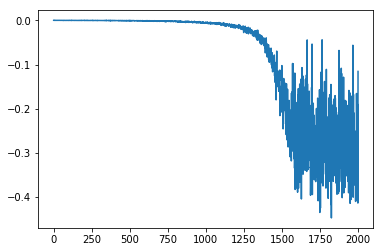

In [4]:
plt.plot(plot_loss)

In [5]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[ 0.1043],
        [-0.8284],
        [ 0.9019],
        [-0.9890],
        [ 0.4584],
        [-0.2227],
        [ 1.2554],
        [-0.9664],
        [ 0.0396]], requires_grad=True)
Parameter containing:
tensor([-0.5202, -0.8933, -0.7307, -0.2283, -1.0029, -0.1433,  0.7146,  0.4010,
        -0.5881], requires_grad=True)
Parameter containing:
tensor([[-0.0329, -0.0754, -0.1579,  0.2204, -0.2755, -0.2265,  0.3373, -0.0868,
         -0.0220],
        [-0.2170,  0.2237,  0.2233,  0.2403, -0.1213, -0.0090, -0.1585,  0.1096,
          0.0258],
        [ 0.0992, -0.2315, -0.1148, -0.2129,  0.0866,  0.3263,  0.2691, -0.0777,
         -0.0186],
        [-0.2091, -0.1186,  0.0785, -0.1648, -0.3153, -0.1816,  0.1770,  0.1340,
          0.3206],
        [ 0.0693, -0.0296, -0.0012, -0.2913, -0.0744,  0.2439,  0.2045,  0.0983,
         -0.0257],
        [-0.0788, -0.0235,  0.1713,  0.1771, -0.2123,  0.1546, -0.1529,  0.0217,
         -0.0858],
        [ 0.2932, -0.166

In [6]:
eval_loss = []
for epoch in tqdm(range(n_epoch)):
    for batch_id, x in enumerate(training_generator):
        loss = model(x)
        eval_loss.append(loss.data.numpy())
        

100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


Text(0.5, 1.0, 'Mean: -0.27722856402397156, Std: 0.07727522403001785')

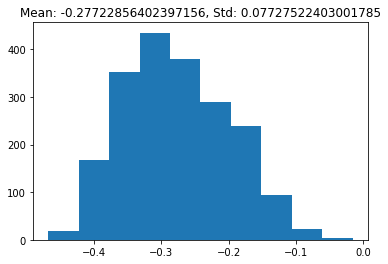

In [8]:
plt.hist(eval_loss)
plt.title(f"Mean: {np.mean(eval_loss)}, Std: {np.std(eval_loss)}")

## 2 channels

In [7]:
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
arrs = []
# for arr in tqdm(glob("../data_2187_1571810501/*")[2500:5000]):
#     z = np.load(arr)['arr_0']
#     x, y = np.random.randint(2187, size=2)
#     z = np.pad(z, pad_width=27, mode='wrap')[x:(x+27), y:(y+27)]
#     arrs.append(z)
# arrs = np.stack(arrs)

arrs = np.load("./ising27x27from2187x2187.npy")[:, None, :, :]
arrs = np.pad(arrs, [(0, 0), (0, 0), (9, 9), (9, 9)], mode='wrap') 

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
S=9
H=15
n_epoch = 100
data_size = 20000
def pad_circular(x, pad):
    """
    function inspired by https://github.com/pytorch/pytorch/issues/3858
    :param x: shape [H, W]
    :param pad: int >= 0
    :return:
    """
    x = torch.cat([x, x[:, 0:pad, :]], dim=1)
    x = torch.cat([x, x[:, :, 0:pad]], dim=2)
    x = torch.cat([x[:, -2 * pad:-pad, :], x], dim=1)
    x = torch.cat([x[:, :, -2 * pad:-pad], x], dim=2)

    return x

class Net(nn.Module):
    def __init__(self, out_channels = 1, filter_size = 3):
        super(Net, self).__init__()
        self.first_channel_MI_net = [nn.Linear(1, S), nn.Linear(S, S), nn.Linear(S, H), 
                                nn.Linear(1, S), nn.Linear(S, S), nn.Linear(S, H), nn.Linear(H, 1)]
        self.second_channel_MI_net = [nn.Linear(1, S), nn.Linear(S, S), nn.Linear(S, H), 
                                 nn.Linear(1, S), nn.Linear(S, S), nn.Linear(S, H), nn.Linear(H, 1)]
        self.interaction_channel_MI_net = [nn.Linear(1, S), nn.Linear(S, S), nn.Linear(S, H), 
                                      nn.Linear(1, S), nn.Linear(S, S), nn.Linear(S, H), nn.Linear(H, 1)]

        
        self.conv1 = nn.Conv2d(1, out_channels, filter_size, padding=0, stride = filter_size)
        
        
    def MI_net(self, x, y, channel_MI_net):
        self.x_fc1, self.x_fc2, self.x_fc3, self.y_fc1, self.y_fc2, self.y_fc3, self.fc3 = channel_MI_net
        inter_x = F.relu(self.x_fc1(x))
        inter_x = inter_x + F.relu(self.x_fc2(inter_x))
        inter_x = self.x_fc3(inter_x)
        
        inter_y = F.relu(self.y_fc1(y))
        inter_y = inter_y + F.relu(self.y_fc2(inter_y))
        inter_y = self.y_fc3(inter_y)
        
        
        h1 = F.relu(inter_x + inter_y)
        h2 = self.fc3(h1)
        return h2  
    
    def compute_channel_MI(self, channel_rectangle, channel_MI_net):
        # separate rectangle into 2 patches of shape 3x3 
        patch1 = channel_rectangle[:, 0].reshape(-1, 1)
        patch2 = channel_rectangle[:, 1].reshape(-1, 1)
        patch2_shuffled = patch2[torch.randperm(patch2.shape[0])]
        
        # compute MI of channel
        pred_xy = self.MI_net(patch1, patch2, channel_MI_net)
        pred_x_y = self.MI_net(patch1, patch2_shuffled, channel_MI_net)
        MI = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        return MI
    
    def forward(self, x):
        # get 9x9 model from 27x27 data: random crop
        i, j = np.random.randint(9, size = 2) 
        x = x[:, :, i:(i+9),j:(j+9)]
        
        # coarse grain 9x9 model to get 3x3 model
        x = (self.conv1(x))
        channel0_rectangle = []
        channel1_rectangle = []
        # get a random 1x2 rectangle
        for data in x:
            i, j = np.random.randint(3, size = 2) 
            channels = pad_circular(data, 2)[:, i, j:(j+2)]
            channel0_rectangle.append(channels[0] )
            channel1_rectangle.append(channels[1] )
        channel0_rectangle = torch.stack(channel0_rectangle)
        channel1_rectangle = torch.stack(channel1_rectangle)
        interaction_rectangle = torch.cat([channel0_rectangle[:, 0].reshape(-1, 1), channel1_rectangle[:, 0].reshape(-1, 1)], dim=1)
        first_channel_MI = self.compute_channel_MI(channel0_rectangle, self.first_channel_MI_net)
        second_channel_MI = self.compute_channel_MI(channel1_rectangle, self.second_channel_MI_net)
        first_second_channel_MI = self.compute_channel_MI(interaction_rectangle, self.interaction_channel_MI_net)
        
        
        
        return -(first_channel_MI + second_channel_MI - first_second_channel_MI), first_channel_MI, second_channel_MI, first_second_channel_MI
        
class IsingDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, arrs):
        'Initialization'
        self.arrs = torch.Tensor(arrs)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.arrs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.arrs[index] 
    
# Generators
# Parameters
params = {'batch_size': 256*4,
          'shuffle': True,
          'num_workers': 6}
training_set = IsingDataset(arrs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

model = Net(out_channels = 2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    
    for batch_id, x in enumerate(training_generator):
        loss = model(x)
        
        plot_loss.append(loss)
        model.zero_grad()
        loss[0].backward() # the first element has the objective
        optimizer.step()
    print("Yes interaction MI: Loss", loss)

        
        
        

  1%|          | 1/100 [00:10<16:39, 10.10s/it]

Yes interaction MI: Loss (tensor(0.0010, grad_fn=<NegBackward>), tensor(-0.0020, grad_fn=<SubBackward0>), tensor(-0.0008, grad_fn=<SubBackward0>), tensor(-0.0018, grad_fn=<SubBackward0>))


  2%|▏         | 2/100 [00:20<16:28, 10.09s/it]

Yes interaction MI: Loss (tensor(-0.0004, grad_fn=<NegBackward>), tensor(-0.0012, grad_fn=<SubBackward0>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(-0.0023, grad_fn=<SubBackward0>))


  3%|▎         | 3/100 [00:30<16:19, 10.09s/it]

Yes interaction MI: Loss (tensor(-0.0009, grad_fn=<NegBackward>), tensor(-0.0010, grad_fn=<SubBackward0>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(-0.0024, grad_fn=<SubBackward0>))


  4%|▍         | 4/100 [00:40<16:18, 10.19s/it]

Yes interaction MI: Loss (tensor(0.0002, grad_fn=<NegBackward>), tensor(-0.0017, grad_fn=<SubBackward0>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(-0.0019, grad_fn=<SubBackward0>))


  5%|▌         | 5/100 [00:50<16:11, 10.22s/it]

Yes interaction MI: Loss (tensor(-0.0017, grad_fn=<NegBackward>), tensor(-0.0013, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0032, grad_fn=<SubBackward0>))


  6%|▌         | 6/100 [01:01<16:00, 10.22s/it]

Yes interaction MI: Loss (tensor(-0.0010, grad_fn=<NegBackward>), tensor(-0.0012, grad_fn=<SubBackward0>), tensor(0.0006, grad_fn=<SubBackward0>), tensor(-0.0017, grad_fn=<SubBackward0>))


  7%|▋         | 7/100 [01:11<15:50, 10.22s/it]

Yes interaction MI: Loss (tensor(-0.0015, grad_fn=<NegBackward>), tensor(-0.0013, grad_fn=<SubBackward0>), tensor(0.0002, grad_fn=<SubBackward0>), tensor(-0.0026, grad_fn=<SubBackward0>))


  8%|▊         | 8/100 [01:21<15:41, 10.23s/it]

Yes interaction MI: Loss (tensor(-0.0007, grad_fn=<NegBackward>), tensor(-0.0014, grad_fn=<SubBackward0>), tensor(8.4817e-05, grad_fn=<SubBackward0>), tensor(-0.0021, grad_fn=<SubBackward0>))


  9%|▉         | 9/100 [01:31<15:21, 10.13s/it]

Yes interaction MI: Loss (tensor(-0.0007, grad_fn=<NegBackward>), tensor(-0.0016, grad_fn=<SubBackward0>), tensor(5.5313e-05, grad_fn=<SubBackward0>), tensor(-0.0023, grad_fn=<SubBackward0>))


 10%|█         | 10/100 [01:41<15:14, 10.16s/it]

Yes interaction MI: Loss (tensor(-0.0017, grad_fn=<NegBackward>), tensor(-0.0013, grad_fn=<SubBackward0>), tensor(0.0002, grad_fn=<SubBackward0>), tensor(-0.0028, grad_fn=<SubBackward0>))


 11%|█         | 11/100 [01:52<15:09, 10.22s/it]

Yes interaction MI: Loss (tensor(-0.0019, grad_fn=<NegBackward>), tensor(-0.0013, grad_fn=<SubBackward0>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(-0.0035, grad_fn=<SubBackward0>))


 12%|█▏        | 12/100 [02:02<14:57, 10.20s/it]

Yes interaction MI: Loss (tensor(-0.0027, grad_fn=<NegBackward>), tensor(-0.0008, grad_fn=<SubBackward0>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(-0.0037, grad_fn=<SubBackward0>))


 13%|█▎        | 13/100 [02:12<14:45, 10.18s/it]

Yes interaction MI: Loss (tensor(-0.0019, grad_fn=<NegBackward>), tensor(-0.0009, grad_fn=<SubBackward0>), tensor(3.3915e-05, grad_fn=<SubBackward0>), tensor(-0.0028, grad_fn=<SubBackward0>))


 14%|█▍        | 14/100 [02:22<14:41, 10.25s/it]

Yes interaction MI: Loss (tensor(-0.0028, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(4.4733e-05, grad_fn=<SubBackward0>), tensor(-0.0034, grad_fn=<SubBackward0>))


 15%|█▌        | 15/100 [02:32<14:23, 10.16s/it]

Yes interaction MI: Loss (tensor(-0.0023, grad_fn=<NegBackward>), tensor(-0.0011, grad_fn=<SubBackward0>), tensor(-0.0001, grad_fn=<SubBackward0>), tensor(-0.0035, grad_fn=<SubBackward0>))


 16%|█▌        | 16/100 [02:43<14:14, 10.18s/it]

Yes interaction MI: Loss (tensor(-0.0022, grad_fn=<NegBackward>), tensor(-0.0008, grad_fn=<SubBackward0>), tensor(-6.5267e-05, grad_fn=<SubBackward0>), tensor(-0.0030, grad_fn=<SubBackward0>))


 17%|█▋        | 17/100 [02:54<14:26, 10.44s/it]

Yes interaction MI: Loss (tensor(-0.0017, grad_fn=<NegBackward>), tensor(-0.0008, grad_fn=<SubBackward0>), tensor(0.0001, grad_fn=<SubBackward0>), tensor(-0.0023, grad_fn=<SubBackward0>))


 18%|█▊        | 18/100 [03:04<14:11, 10.38s/it]

Yes interaction MI: Loss (tensor(-0.0026, grad_fn=<NegBackward>), tensor(-0.0011, grad_fn=<SubBackward0>), tensor(5.4210e-05, grad_fn=<SubBackward0>), tensor(-0.0037, grad_fn=<SubBackward0>))


 19%|█▉        | 19/100 [03:14<13:56, 10.32s/it]

Yes interaction MI: Loss (tensor(-0.0024, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(-3.1263e-05, grad_fn=<SubBackward0>), tensor(-0.0031, grad_fn=<SubBackward0>))


 20%|██        | 20/100 [03:24<13:44, 10.31s/it]

Yes interaction MI: Loss (tensor(-0.0028, grad_fn=<NegBackward>), tensor(-0.0008, grad_fn=<SubBackward0>), tensor(0.0002, grad_fn=<SubBackward0>), tensor(-0.0033, grad_fn=<SubBackward0>))


 21%|██        | 21/100 [03:35<13:34, 10.32s/it]

Yes interaction MI: Loss (tensor(-0.0029, grad_fn=<NegBackward>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(-2.9117e-05, grad_fn=<SubBackward0>), tensor(-0.0032, grad_fn=<SubBackward0>))


 22%|██▏       | 22/100 [03:45<13:21, 10.28s/it]

Yes interaction MI: Loss (tensor(-0.0029, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(5.4866e-05, grad_fn=<SubBackward0>), tensor(-0.0035, grad_fn=<SubBackward0>))


 23%|██▎       | 23/100 [03:55<13:10, 10.26s/it]

Yes interaction MI: Loss (tensor(-0.0029, grad_fn=<NegBackward>), tensor(-0.0012, grad_fn=<SubBackward0>), tensor(7.4714e-05, grad_fn=<SubBackward0>), tensor(-0.0040, grad_fn=<SubBackward0>))


 24%|██▍       | 24/100 [04:05<12:53, 10.18s/it]

Yes interaction MI: Loss (tensor(-0.0024, grad_fn=<NegBackward>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(0.0003, grad_fn=<SubBackward0>), tensor(-0.0025, grad_fn=<SubBackward0>))


 25%|██▌       | 25/100 [04:15<12:40, 10.15s/it]

Yes interaction MI: Loss (tensor(-0.0031, grad_fn=<NegBackward>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(0.0001, grad_fn=<SubBackward0>), tensor(-0.0034, grad_fn=<SubBackward0>))


 26%|██▌       | 26/100 [04:25<12:32, 10.17s/it]

Yes interaction MI: Loss (tensor(-0.0036, grad_fn=<NegBackward>), tensor(-5.3488e-05, grad_fn=<SubBackward0>), tensor(0.0004, grad_fn=<SubBackward0>), tensor(-0.0033, grad_fn=<SubBackward0>))


 27%|██▋       | 27/100 [04:36<12:24, 10.20s/it]

Yes interaction MI: Loss (tensor(-0.0027, grad_fn=<NegBackward>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(4.4495e-05, grad_fn=<SubBackward0>), tensor(-0.0030, grad_fn=<SubBackward0>))


 28%|██▊       | 28/100 [04:46<12:14, 10.20s/it]

Yes interaction MI: Loss (tensor(-0.0033, grad_fn=<NegBackward>), tensor(-0.0009, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0045, grad_fn=<SubBackward0>))


 29%|██▉       | 29/100 [04:56<11:58, 10.12s/it]

Yes interaction MI: Loss (tensor(-0.0032, grad_fn=<NegBackward>), tensor(-0.0011, grad_fn=<SubBackward0>), tensor(-0.0001, grad_fn=<SubBackward0>), tensor(-0.0045, grad_fn=<SubBackward0>))


 30%|███       | 30/100 [05:06<11:43, 10.05s/it]

Yes interaction MI: Loss (tensor(-0.0022, grad_fn=<NegBackward>), tensor(-0.0009, grad_fn=<SubBackward0>), tensor(3.8147e-05, grad_fn=<SubBackward0>), tensor(-0.0031, grad_fn=<SubBackward0>))


 31%|███       | 31/100 [05:16<11:37, 10.11s/it]

Yes interaction MI: Loss (tensor(-0.0028, grad_fn=<NegBackward>), tensor(-0.0010, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0040, grad_fn=<SubBackward0>))


 32%|███▏      | 32/100 [05:26<11:28, 10.12s/it]

Yes interaction MI: Loss (tensor(-0.0027, grad_fn=<NegBackward>), tensor(-0.0006, grad_fn=<SubBackward0>), tensor(5.8323e-05, grad_fn=<SubBackward0>), tensor(-0.0033, grad_fn=<SubBackward0>))


 33%|███▎      | 33/100 [05:36<11:13, 10.06s/it]

Yes interaction MI: Loss (tensor(-0.0030, grad_fn=<NegBackward>), tensor(-4.6916e-05, grad_fn=<SubBackward0>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(-0.0033, grad_fn=<SubBackward0>))


 34%|███▍      | 34/100 [05:46<11:00, 10.01s/it]

Yes interaction MI: Loss (tensor(-0.0034, grad_fn=<NegBackward>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(0.0001, grad_fn=<SubBackward0>), tensor(-0.0036, grad_fn=<SubBackward0>))


 35%|███▌      | 35/100 [05:56<10:53, 10.06s/it]

Yes interaction MI: Loss (tensor(-0.0026, grad_fn=<NegBackward>), tensor(-0.0005, grad_fn=<SubBackward0>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(-0.0033, grad_fn=<SubBackward0>))


 36%|███▌      | 36/100 [06:06<10:45, 10.08s/it]

Yes interaction MI: Loss (tensor(-0.0035, grad_fn=<NegBackward>), tensor(-0.0006, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0044, grad_fn=<SubBackward0>))


 37%|███▋      | 37/100 [06:16<10:39, 10.15s/it]

Yes interaction MI: Loss (tensor(-0.0025, grad_fn=<NegBackward>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(-7.8231e-05, grad_fn=<SubBackward0>), tensor(-0.0031, grad_fn=<SubBackward0>))


 38%|███▊      | 38/100 [06:26<10:24, 10.07s/it]

Yes interaction MI: Loss (tensor(-0.0037, grad_fn=<NegBackward>), tensor(-0.0005, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0043, grad_fn=<SubBackward0>))


 39%|███▉      | 39/100 [06:37<10:17, 10.13s/it]

Yes interaction MI: Loss (tensor(-0.0029, grad_fn=<NegBackward>), tensor(-0.0005, grad_fn=<SubBackward0>), tensor(0.0001, grad_fn=<SubBackward0>), tensor(-0.0033, grad_fn=<SubBackward0>))


 40%|████      | 40/100 [06:47<10:12, 10.20s/it]

Yes interaction MI: Loss (tensor(-0.0029, grad_fn=<NegBackward>), tensor(-0.0006, grad_fn=<SubBackward0>), tensor(-3.3677e-06, grad_fn=<SubBackward0>), tensor(-0.0035, grad_fn=<SubBackward0>))


 41%|████      | 41/100 [06:57<09:59, 10.16s/it]

Yes interaction MI: Loss (tensor(-0.0037, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0047, grad_fn=<SubBackward0>))


 42%|████▏     | 42/100 [07:07<09:45, 10.10s/it]

Yes interaction MI: Loss (tensor(-0.0034, grad_fn=<NegBackward>), tensor(-0.0011, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0047, grad_fn=<SubBackward0>))


 43%|████▎     | 43/100 [07:17<09:27,  9.96s/it]

Yes interaction MI: Loss (tensor(-0.0031, grad_fn=<NegBackward>), tensor(-0.0005, grad_fn=<SubBackward0>), tensor(-5.1886e-05, grad_fn=<SubBackward0>), tensor(-0.0036, grad_fn=<SubBackward0>))


 44%|████▍     | 44/100 [07:27<09:22, 10.04s/it]

Yes interaction MI: Loss (tensor(-0.0025, grad_fn=<NegBackward>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(-0.0031, grad_fn=<SubBackward0>))


 45%|████▌     | 45/100 [07:37<09:13, 10.06s/it]

Yes interaction MI: Loss (tensor(-0.0035, grad_fn=<NegBackward>), tensor(-0.0005, grad_fn=<SubBackward0>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(-0.0044, grad_fn=<SubBackward0>))


 46%|████▌     | 46/100 [07:47<09:03, 10.07s/it]

Yes interaction MI: Loss (tensor(-0.0035, grad_fn=<NegBackward>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(0.0004, grad_fn=<SubBackward0>), tensor(-0.0034, grad_fn=<SubBackward0>))


 47%|████▋     | 47/100 [07:57<08:56, 10.12s/it]

Yes interaction MI: Loss (tensor(-0.0037, grad_fn=<NegBackward>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(-0.0044, grad_fn=<SubBackward0>))


 48%|████▊     | 48/100 [08:07<08:44, 10.09s/it]

Yes interaction MI: Loss (tensor(-0.0030, grad_fn=<NegBackward>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(0.0002, grad_fn=<SubBackward0>), tensor(-0.0031, grad_fn=<SubBackward0>))


 49%|████▉     | 49/100 [08:17<08:31, 10.04s/it]

Yes interaction MI: Loss (tensor(-0.0033, grad_fn=<NegBackward>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(0.0002, grad_fn=<SubBackward0>), tensor(-0.0035, grad_fn=<SubBackward0>))


 50%|█████     | 50/100 [08:27<08:22, 10.06s/it]

Yes interaction MI: Loss (tensor(-0.0035, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(2.6822e-05, grad_fn=<SubBackward0>), tensor(-0.0042, grad_fn=<SubBackward0>))


 51%|█████     | 51/100 [08:37<08:13, 10.07s/it]

Yes interaction MI: Loss (tensor(-0.0033, grad_fn=<NegBackward>), tensor(-0.0006, grad_fn=<SubBackward0>), tensor(6.6221e-05, grad_fn=<SubBackward0>), tensor(-0.0038, grad_fn=<SubBackward0>))


 52%|█████▏    | 52/100 [08:48<08:05, 10.11s/it]

Yes interaction MI: Loss (tensor(-0.0040, grad_fn=<NegBackward>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(1.5825e-05, grad_fn=<SubBackward0>), tensor(-0.0043, grad_fn=<SubBackward0>))


 53%|█████▎    | 53/100 [08:58<07:54, 10.10s/it]

Yes interaction MI: Loss (tensor(-0.0034, grad_fn=<NegBackward>), tensor(-0.0010, grad_fn=<SubBackward0>), tensor(0.0003, grad_fn=<SubBackward0>), tensor(-0.0041, grad_fn=<SubBackward0>))


 54%|█████▍    | 54/100 [09:08<07:40, 10.01s/it]

Yes interaction MI: Loss (tensor(-0.0039, grad_fn=<NegBackward>), tensor(-0.0006, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0047, grad_fn=<SubBackward0>))


 55%|█████▌    | 55/100 [09:18<07:35, 10.11s/it]

Yes interaction MI: Loss (tensor(-0.0049, grad_fn=<NegBackward>), tensor(-0.0009, grad_fn=<SubBackward0>), tensor(-0.0001, grad_fn=<SubBackward0>), tensor(-0.0059, grad_fn=<SubBackward0>))


 56%|█████▌    | 56/100 [09:28<07:24, 10.10s/it]

Yes interaction MI: Loss (tensor(-0.0045, grad_fn=<NegBackward>), tensor(-0.0006, grad_fn=<SubBackward0>), tensor(4.6194e-05, grad_fn=<SubBackward0>), tensor(-0.0051, grad_fn=<SubBackward0>))


 57%|█████▋    | 57/100 [09:38<07:13, 10.09s/it]

Yes interaction MI: Loss (tensor(-0.0055, grad_fn=<NegBackward>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(0.0003, grad_fn=<SubBackward0>), tensor(-0.0056, grad_fn=<SubBackward0>))


 58%|█████▊    | 58/100 [09:48<07:06, 10.14s/it]

Yes interaction MI: Loss (tensor(-0.0066, grad_fn=<NegBackward>), tensor(-0.0005, grad_fn=<SubBackward0>), tensor(0.0003, grad_fn=<SubBackward0>), tensor(-0.0068, grad_fn=<SubBackward0>))


 59%|█████▉    | 59/100 [09:58<06:54, 10.12s/it]

Yes interaction MI: Loss (tensor(-0.0063, grad_fn=<NegBackward>), tensor(-0.0013, grad_fn=<SubBackward0>), tensor(0.0001, grad_fn=<SubBackward0>), tensor(-0.0075, grad_fn=<SubBackward0>))


 60%|██████    | 60/100 [10:08<06:42, 10.07s/it]

Yes interaction MI: Loss (tensor(-0.0066, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(0.0001, grad_fn=<SubBackward0>), tensor(-0.0072, grad_fn=<SubBackward0>))


 61%|██████    | 61/100 [10:18<06:33, 10.09s/it]

Yes interaction MI: Loss (tensor(-0.0061, grad_fn=<NegBackward>), tensor(-0.0009, grad_fn=<SubBackward0>), tensor(7.8082e-05, grad_fn=<SubBackward0>), tensor(-0.0069, grad_fn=<SubBackward0>))


 62%|██████▏   | 62/100 [10:29<06:25, 10.14s/it]

Yes interaction MI: Loss (tensor(-0.0070, grad_fn=<NegBackward>), tensor(-0.0010, grad_fn=<SubBackward0>), tensor(-2.3335e-05, grad_fn=<SubBackward0>), tensor(-0.0080, grad_fn=<SubBackward0>))


 63%|██████▎   | 63/100 [10:39<06:18, 10.24s/it]

Yes interaction MI: Loss (tensor(-0.0059, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(0.0001, grad_fn=<SubBackward0>), tensor(-0.0066, grad_fn=<SubBackward0>))


 64%|██████▍   | 64/100 [10:49<06:05, 10.15s/it]

Yes interaction MI: Loss (tensor(-0.0069, grad_fn=<NegBackward>), tensor(-0.0010, grad_fn=<SubBackward0>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(-0.0084, grad_fn=<SubBackward0>))


 65%|██████▌   | 65/100 [10:59<05:54, 10.12s/it]

Yes interaction MI: Loss (tensor(-0.0061, grad_fn=<NegBackward>), tensor(-0.0012, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0075, grad_fn=<SubBackward0>))


 66%|██████▌   | 66/100 [11:09<05:41, 10.03s/it]

Yes interaction MI: Loss (tensor(-0.0074, grad_fn=<NegBackward>), tensor(-0.0006, grad_fn=<SubBackward0>), tensor(-0.0005, grad_fn=<SubBackward0>), tensor(-0.0085, grad_fn=<SubBackward0>))


 67%|██████▋   | 67/100 [11:19<05:32, 10.08s/it]

Yes interaction MI: Loss (tensor(-0.0067, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(-0.0078, grad_fn=<SubBackward0>))


 68%|██████▊   | 68/100 [11:29<05:23, 10.11s/it]

Yes interaction MI: Loss (tensor(-0.0065, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(-0.0076, grad_fn=<SubBackward0>))


 69%|██████▉   | 69/100 [11:39<05:08,  9.96s/it]

Yes interaction MI: Loss (tensor(-0.0064, grad_fn=<NegBackward>), tensor(-0.0006, grad_fn=<SubBackward0>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(-0.0074, grad_fn=<SubBackward0>))


 70%|███████   | 70/100 [11:49<05:00, 10.02s/it]

Yes interaction MI: Loss (tensor(-0.0068, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(-2.9445e-05, grad_fn=<SubBackward0>), tensor(-0.0075, grad_fn=<SubBackward0>))


 71%|███████   | 71/100 [11:59<04:51, 10.05s/it]

Yes interaction MI: Loss (tensor(-0.0077, grad_fn=<NegBackward>), tensor(-0.0011, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0089, grad_fn=<SubBackward0>))


 72%|███████▏  | 72/100 [12:10<04:43, 10.11s/it]

Yes interaction MI: Loss (tensor(-0.0068, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(-0.0078, grad_fn=<SubBackward0>))


 73%|███████▎  | 73/100 [12:20<04:33, 10.14s/it]

Yes interaction MI: Loss (tensor(-0.0068, grad_fn=<NegBackward>), tensor(-0.0006, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0076, grad_fn=<SubBackward0>))


 74%|███████▍  | 74/100 [12:30<04:21, 10.08s/it]

Yes interaction MI: Loss (tensor(-0.0075, grad_fn=<NegBackward>), tensor(-0.0011, grad_fn=<SubBackward0>), tensor(-0.0006, grad_fn=<SubBackward0>), tensor(-0.0091, grad_fn=<SubBackward0>))


 75%|███████▌  | 75/100 [12:40<04:13, 10.13s/it]

Yes interaction MI: Loss (tensor(-0.0070, grad_fn=<NegBackward>), tensor(-0.0008, grad_fn=<SubBackward0>), tensor(-0.0005, grad_fn=<SubBackward0>), tensor(-0.0083, grad_fn=<SubBackward0>))


 76%|███████▌  | 76/100 [12:50<04:03, 10.15s/it]

Yes interaction MI: Loss (tensor(-0.0073, grad_fn=<NegBackward>), tensor(-0.0010, grad_fn=<SubBackward0>), tensor(-6.9439e-06, grad_fn=<SubBackward0>), tensor(-0.0083, grad_fn=<SubBackward0>))


 77%|███████▋  | 77/100 [13:00<03:52, 10.12s/it]

Yes interaction MI: Loss (tensor(-0.0070, grad_fn=<NegBackward>), tensor(-0.0012, grad_fn=<SubBackward0>), tensor(-0.0006, grad_fn=<SubBackward0>), tensor(-0.0088, grad_fn=<SubBackward0>))


 78%|███████▊  | 78/100 [13:10<03:42, 10.12s/it]

Yes interaction MI: Loss (tensor(-0.0084, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(-0.0005, grad_fn=<SubBackward0>), tensor(-0.0097, grad_fn=<SubBackward0>))


 79%|███████▉  | 79/100 [13:20<03:31, 10.09s/it]

Yes interaction MI: Loss (tensor(-0.0079, grad_fn=<NegBackward>), tensor(-0.0008, grad_fn=<SubBackward0>), tensor(-5.5194e-05, grad_fn=<SubBackward0>), tensor(-0.0087, grad_fn=<SubBackward0>))


 80%|████████  | 80/100 [13:30<03:21, 10.07s/it]

Yes interaction MI: Loss (tensor(-0.0081, grad_fn=<NegBackward>), tensor(-0.0010, grad_fn=<SubBackward0>), tensor(0.0004, grad_fn=<SubBackward0>), tensor(-0.0086, grad_fn=<SubBackward0>))


 81%|████████  | 81/100 [13:40<03:11, 10.10s/it]

Yes interaction MI: Loss (tensor(-0.0072, grad_fn=<NegBackward>), tensor(-0.0011, grad_fn=<SubBackward0>), tensor(-0.0005, grad_fn=<SubBackward0>), tensor(-0.0088, grad_fn=<SubBackward0>))


 82%|████████▏ | 82/100 [13:51<03:02, 10.14s/it]

Yes interaction MI: Loss (tensor(-0.0078, grad_fn=<NegBackward>), tensor(-0.0010, grad_fn=<SubBackward0>), tensor(8.5831e-06, grad_fn=<SubBackward0>), tensor(-0.0088, grad_fn=<SubBackward0>))


 83%|████████▎ | 83/100 [14:01<02:50, 10.04s/it]

Yes interaction MI: Loss (tensor(-0.0081, grad_fn=<NegBackward>), tensor(-0.0008, grad_fn=<SubBackward0>), tensor(-0.0001, grad_fn=<SubBackward0>), tensor(-0.0090, grad_fn=<SubBackward0>))


 84%|████████▍ | 84/100 [14:11<02:41, 10.11s/it]

Yes interaction MI: Loss (tensor(-0.0075, grad_fn=<NegBackward>), tensor(-0.0016, grad_fn=<SubBackward0>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(-0.0095, grad_fn=<SubBackward0>))


 85%|████████▌ | 85/100 [14:21<02:30, 10.06s/it]

Yes interaction MI: Loss (tensor(-0.0086, grad_fn=<NegBackward>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(-0.0090, grad_fn=<SubBackward0>))


 86%|████████▌ | 86/100 [14:31<02:21, 10.08s/it]

Yes interaction MI: Loss (tensor(-0.0080, grad_fn=<NegBackward>), tensor(-0.0011, grad_fn=<SubBackward0>), tensor(-0.0004, grad_fn=<SubBackward0>), tensor(-0.0095, grad_fn=<SubBackward0>))


 87%|████████▋ | 87/100 [14:41<02:10, 10.05s/it]

Yes interaction MI: Loss (tensor(-0.0083, grad_fn=<NegBackward>), tensor(-0.0008, grad_fn=<SubBackward0>), tensor(0.0001, grad_fn=<SubBackward0>), tensor(-0.0090, grad_fn=<SubBackward0>))


 88%|████████▊ | 88/100 [14:51<02:00, 10.04s/it]

Yes interaction MI: Loss (tensor(-0.0081, grad_fn=<NegBackward>), tensor(-0.0018, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0102, grad_fn=<SubBackward0>))


 89%|████████▉ | 89/100 [15:01<01:49,  9.99s/it]

Yes interaction MI: Loss (tensor(-0.0076, grad_fn=<NegBackward>), tensor(-0.0007, grad_fn=<SubBackward0>), tensor(-7.5668e-05, grad_fn=<SubBackward0>), tensor(-0.0084, grad_fn=<SubBackward0>))


 90%|█████████ | 90/100 [15:11<01:40, 10.02s/it]

Yes interaction MI: Loss (tensor(-0.0082, grad_fn=<NegBackward>), tensor(-0.0018, grad_fn=<SubBackward0>), tensor(0.0002, grad_fn=<SubBackward0>), tensor(-0.0098, grad_fn=<SubBackward0>))


 91%|█████████ | 91/100 [15:21<01:30, 10.09s/it]

Yes interaction MI: Loss (tensor(-0.0089, grad_fn=<NegBackward>), tensor(-0.0019, grad_fn=<SubBackward0>), tensor(6.7502e-05, grad_fn=<SubBackward0>), tensor(-0.0107, grad_fn=<SubBackward0>))


 92%|█████████▏| 92/100 [15:31<01:20, 10.11s/it]

Yes interaction MI: Loss (tensor(-0.0092, grad_fn=<NegBackward>), tensor(-0.0015, grad_fn=<SubBackward0>), tensor(-0.0003, grad_fn=<SubBackward0>), tensor(-0.0110, grad_fn=<SubBackward0>))


 93%|█████████▎| 93/100 [15:41<01:10, 10.09s/it]

Yes interaction MI: Loss (tensor(-0.0082, grad_fn=<NegBackward>), tensor(-0.0023, grad_fn=<SubBackward0>), tensor(3.9071e-05, grad_fn=<SubBackward0>), tensor(-0.0104, grad_fn=<SubBackward0>))


 94%|█████████▍| 94/100 [15:51<01:00, 10.12s/it]

Yes interaction MI: Loss (tensor(-0.0095, grad_fn=<NegBackward>), tensor(-0.0005, grad_fn=<SubBackward0>), tensor(-1.1623e-06, grad_fn=<SubBackward0>), tensor(-0.0099, grad_fn=<SubBackward0>))


 95%|█████████▌| 95/100 [16:02<00:50, 10.10s/it]

Yes interaction MI: Loss (tensor(-0.0082, grad_fn=<NegBackward>), tensor(-0.0009, grad_fn=<SubBackward0>), tensor(-4.5568e-05, grad_fn=<SubBackward0>), tensor(-0.0091, grad_fn=<SubBackward0>))


 96%|█████████▌| 96/100 [16:12<00:40, 10.08s/it]

Yes interaction MI: Loss (tensor(-0.0083, grad_fn=<NegBackward>), tensor(-0.0006, grad_fn=<SubBackward0>), tensor(-0.0001, grad_fn=<SubBackward0>), tensor(-0.0090, grad_fn=<SubBackward0>))


 97%|█████████▋| 97/100 [16:22<00:30, 10.12s/it]

Yes interaction MI: Loss (tensor(-0.0076, grad_fn=<NegBackward>), tensor(-0.0014, grad_fn=<SubBackward0>), tensor(-0.0008, grad_fn=<SubBackward0>), tensor(-0.0098, grad_fn=<SubBackward0>))


 98%|█████████▊| 98/100 [16:31<00:19, 10.00s/it]

Yes interaction MI: Loss (tensor(-0.0084, grad_fn=<NegBackward>), tensor(-0.0020, grad_fn=<SubBackward0>), tensor(0.0002, grad_fn=<SubBackward0>), tensor(-0.0103, grad_fn=<SubBackward0>))


 99%|█████████▉| 99/100 [16:41<00:09,  9.74s/it]

Yes interaction MI: Loss (tensor(-0.0093, grad_fn=<NegBackward>), tensor(-0.0010, grad_fn=<SubBackward0>), tensor(-0.0005, grad_fn=<SubBackward0>), tensor(-0.0108, grad_fn=<SubBackward0>))


100%|██████████| 100/100 [16:51<00:00, 10.11s/it]

Yes interaction MI: Loss (tensor(-0.0078, grad_fn=<NegBackward>), tensor(-0.0011, grad_fn=<SubBackward0>), tensor(-0.0002, grad_fn=<SubBackward0>), tensor(-0.0091, grad_fn=<SubBackward0>))


In [4]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[[[-0.1272, -0.1586, -0.0753],
          [-0.0342,  0.0594, -0.0816],
          [ 0.0129, -0.2169, -0.1285]]],


        [[[ 0.1150, -0.2118, -0.1909],
          [ 0.0208,  0.2179,  0.1040],
          [-0.0947, -0.1896,  0.2616]]]], requires_grad=True)
Parameter containing:
tensor([-0.2433, -0.3636], requires_grad=True)
Parameter containing:
tensor([[-0.7747],
        [ 0.7862],
        [-0.8603],
        [ 0.0952],
        [-0.8302],
        [ 0.9457],
        [-0.3454],
        [-0.2021],
        [ 0.9451]], requires_grad=True)
Parameter containing:
tensor([-0.9897,  0.6293,  0.0494,  0.6762, -0.4896,  0.9121,  0.2383, -0.5952,
         0.8130], requires_grad=True)
Parameter containing:
tensor([[ 0.0572, -0.1845, -0.2029,  0.2157, -0.3288,  0.2891, -0.2793,  0.0452,
          0.3021],
        [-0.0630, -0.0401, -0.0223,  0.1232, -0.1496,  0.2679, -0.3203, -0.1830,
          0.1960],
        [-0.1616, -0.1954, -0.0254, -0.0939,  0.0475, -0.2806, -0.0517, 

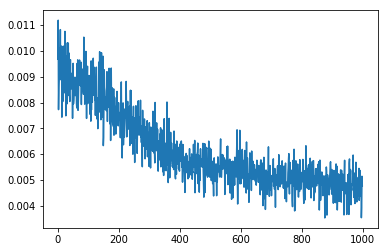

In [5]:
plt.plot(plot_loss)